## Runs DE on different clusters. 
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/SE.rds"
sample_names = "Control,Flt3l,Input"
outdir = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02"

# Parameters
assay="RNA"
minPct = 0.00
logfcthresh = 0.1
top_de = 3
p_thresh=0.1
# test.use="wilcox"
# latent.vars = "NULL"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

input_cond = "Input"

rerun_embed = FALSE

In [2]:
source(utils_script)
outdir = outdir
dir.create(outdir, showWarnings = FALSE)


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "Control" "Flt3l"   "Input"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
221404 features across 18672 samples within 2 assays 
Active assay: RNA (19039 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [6]:
table(se$orig.ident)


Control   Flt3l   Input 
   5084    7207    6381 

## subset by the input and re-run umap

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



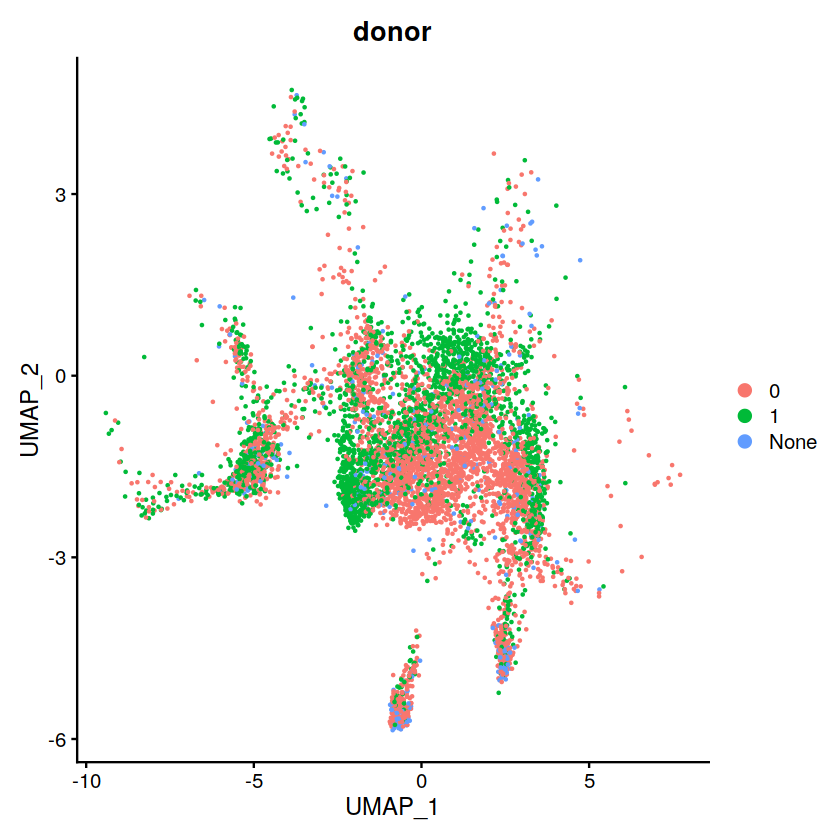

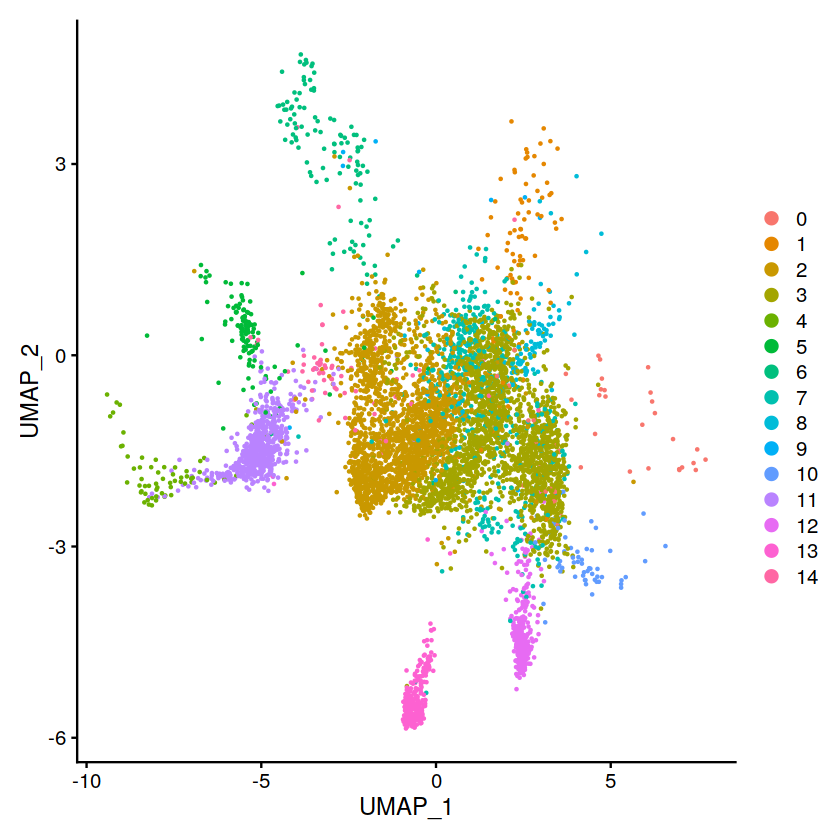

In [7]:
expr <- FetchData(se, vars = "orig.ident")
se <- se[, which(expr == input_cond)]
#curr.se
#p1 <- DimPlot(curr.se , group.by = "condition")
p <- DimPlot(se , group.by = "donor") #split.by=mt)
ggsave(file.path(outdir, "input.umap.donor.png"))
p2 <- DimPlot(se) #split.by=mt)
ggsave(file.path(outdir, "input.umap.png"))
p
p2

In [8]:
se

An object of class Seurat 
221404 features across 6381 samples within 2 assays 
Active assay: RNA (19039 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [9]:
if (rerun_embed){
    print("Embedding on just Input")
    DefaultAssay(se) <- "ATAC"
    se <- embed.atac(se, outdir=NULL, lsi_start_comp=2, 
                     lsi_end_comp=50,reduction='lsi', neighbor_dim=30,return.depth=F)
    
    Idents(se) <- "seurat.clusters"
    p1 <- DimPlot(se)
    
    p1
    p2 <- DimPlot(se , group.by = "donor") #split.by=mt)
    p2
    DefaultAssay(se) <- "RNA"
    
}

## Run DE for  cluster vs all others 

[1] "cluster 0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
LILRB4 1.680740e-16  0.2589698 0.367 0.068 3.199960e-12
PRSS8  3.693823e-15  0.1523890 0.265 0.040 7.032669e-11
SHC3   1.300202e-11  0.3594911 0.694 0.290 2.475455e-07
GPR88  1.007255e-10  0.1921534 0.408 0.112 1.917713e-06
CXCR5  1.911204e-10  0.1494658 0.327 0.078 3.638741e-06
RBM47  6.770215e-10  0.6175955 0.878 0.593 1.288981e-05
[1] "saved cluster 0"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
MNDA   8.702149e-13  0.1109270 0.213 0.048 1.656802e-08
TREM1  1.692755e-09  0.1967330 0.461 0.199 3.222837e-05
CDA    2.255932e-09  0.2286145 0.303 0.109 4.295069e-05
SRPK1  1.218518e-08  0.2297985 0.449 0.209 2.319937e-04
GJB6   1.510202e-08  0.1283982 0.225 0.069 2.875273e-04
ZNF274 3.027105e-08  0.1400484 0.348 0.138 5.763305e-04
[1] "saved cluster 1"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 2"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
STXBP4 1.444796e-70  0.3234813 0.524 0.336 2.750747e-66
GBP5   5.771940e-62  0.2345411 0.371 0.197 1.098920e-57
CDH7   6.296195e-61  0.2826013 0.443 0.269 1.198733e-56
PRKCD  3.637440e-57 -0.2061194 0.194 0.397 6.925321e-53
FNDC3B 3.422179e-56 -0.3336139 0.752 0.840 6.515486e-52
PAG1   9.640002e-54 -0.2507497 0.473 0.669 1.835360e-49
[1] "saved cluster 2"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 3"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj
FNDC3B   2.681228e-116  0.4199917 0.910 0.768 5.104790e-112
HRH2     3.277582e-115  0.2490083 0.541 0.239 6.240189e-111
TM4SF20   2.618007e-92  0.1426143 0.302 0.094  4.984423e-88
ARHGAP26  2.370965e-82  0.3295712 0.953 0.902  4.514079e-78
PLEK      4.039935e-80  0.2124438 0.578 0.316  7.691633e-76
NEDD9     7.789418e-78  0.2771485 0.769 0.544  1.483027e-73
[1] "saved cluster 3"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 4"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
FGB    2.130568e-27  0.2558245 0.306 0.038 4.056388e-23
EGFL8  6.808010e-20  0.1173670 0.145 0.012 1.296177e-15
PAPPA  2.175191e-19  0.6933287 0.726 0.285 4.141345e-15
AHSP   1.717937e-18  0.1003251 0.129 0.010 3.270781e-14
GDF2   1.868846e-17  0.1430934 0.145 0.014 3.558096e-13
DNAJC6 1.873663e-14  0.8099137 0.758 0.438 3.567267e-10
[1] "saved cluster 4"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 5"
                p_val avg_log2FC pct.1 pct.2    p_val_adj
ABCC4    1.179951e-16  0.4494771 0.911 0.712 2.246509e-12
CMTM5    3.577459e-15  0.1508061 0.169 0.035 6.811124e-11
ARHGAP26 1.057611e-13 -0.4951176 0.887 0.919 2.013586e-09
TUBB1    5.228813e-12  0.1294086 0.202 0.056 9.955138e-08
STAU2    1.083234e-11  0.3605069 0.806 0.595 2.062369e-07
TRPC6    1.506367e-11  0.3791280 0.677 0.448 2.867973e-07
[1] "saved cluster 5"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 6"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
IL1RL1 2.595089e-17  0.3893434 0.397 0.146 4.940789e-13
ADAM20 7.923050e-17  0.1410044 0.121 0.017 1.508469e-12
NIBAN1 1.612850e-12  0.5372001 0.836 0.680 3.070704e-08
FNDC3B 3.622886e-12  0.4667811 0.914 0.811 6.897613e-08
MTCL1  8.060460e-11  0.4374754 0.638 0.437 1.534631e-06
HDC    1.239793e-10  0.3880010 0.491 0.277 2.360442e-06
[1] "saved cluster 6"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 7"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
KIFAP3 7.601911e-12 -0.1814480 0.294 0.499 1.447328e-07
PTPN14 1.111541e-11  0.2697832 0.638 0.567 2.116262e-07
PDE6A  9.907833e-11 -0.1033735 0.121 0.274 1.886352e-06
CTDP1  1.428232e-10 -0.1279875 0.297 0.495 2.719211e-06
MICU1  1.475256e-10 -0.1266285 0.217 0.392 2.808740e-06
VAV2   4.180937e-10 -0.1268003 0.222 0.396 7.960086e-06
[1] "saved cluster 7"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 8"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
OR9Q1   1.082304e-08  0.1610702 0.327 0.132 0.0002060599
XKR4    2.882887e-08  0.2648601 0.673 0.426 0.0005488728
CACNA1E 3.944262e-08  0.3045096 0.663 0.429 0.0007509480
DSCAML1 6.347643e-08  0.2996004 0.894 0.656 0.0012085278
NOS1    8.083100e-08  0.2095611 0.433 0.214 0.0015389414
PPP3CA  1.476629e-07 -0.3848197 0.721 0.776 0.0028113547
[1] "saved cluster 8"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 9"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
ETV6    4.926910e-10 -1.5280408 0.059 0.892 9.380345e-06
FAM47A  5.543660e-08  0.2073119 0.059 0.002 1.055457e-03
ANKRD44 3.511464e-07 -0.9269130 0.118 0.885 6.685477e-03
CCND3   5.328157e-07 -0.8580965 0.000 0.693 1.014428e-02
FBXO11  7.701488e-07 -0.8108254 0.000 0.682 1.466286e-02
LIMD1   1.237143e-06 -0.8096375 0.000 0.667 2.355397e-02
[1] "saved cluster 9"


Warning message:
"Only one identity present, the expression values will be not scaled"
Warning message in FeaturePlot(se.filt, features = names.sig):
"All cells have the same value (0) of CCND3."
Warning message in FeaturePlot(se.filt, features = names.sig):
"All cells have the same value (0) of FBXO11."
Warning message in FeaturePlot(se.filt, features = names.sig):
"All cells have the same value (0) of LIMD1."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of CCND3."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of FBXO11."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of LIMD1."
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 10"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
C2orf91 1.413444e-31  0.2871656 0.439 0.061 2.691056e-27
SLAMF7  7.387311e-19  0.2414537 0.386 0.076 1.406470e-14
DUSP22  3.755870e-14  0.6074315 0.895 0.553 7.150801e-10
CLRN3   1.009772e-13  0.2457859 0.351 0.083 1.922505e-09
P2RY6   1.180151e-13  0.4248014 0.579 0.217 2.246890e-09
SAMHD1  3.746000e-12  0.4266320 0.614 0.259 7.132010e-08
[1] "saved cluster 10"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 11"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
GYPB    5.761114e-112  0.2428990 0.316 0.060 1.096858e-107
ANKRD61 4.360625e-108  0.1647582 0.215 0.026 8.302194e-104
MAGEB16 7.721534e-101  0.1390414 0.150 0.011  1.470103e-96
CXADR    5.893781e-93  0.4315471 0.621 0.274  1.122117e-88
GAS7     2.739031e-92 -0.6763486 0.384 0.728  5.214841e-88
AKAP4    2.609222e-89  0.1201360 0.147 0.013  4.967697e-85
[1] "saved cluster 11"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 12"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj
OR10T2   2.725401e-132  0.1508134 0.167 0.005 5.188891e-128
KCNK1     3.073842e-87  0.3371380 0.415 0.081  5.852287e-83
PTCRA     1.081482e-72  0.1616174 0.212 0.024  2.059034e-68
TNFRSF17  4.223477e-58  0.1161863 0.135 0.012  8.041077e-54
PDZRN3    1.754121e-52  0.5426902 0.711 0.368  3.339670e-48
FAM160A1  4.643906e-52  0.5162730 0.797 0.455  8.841532e-48
[1] "saved cluster 12"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 13"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
ADPRHL1 1.476829e-114  0.5112066 0.512 0.101 2.811735e-110
FAM163B 4.720449e-110  0.3558038 0.359 0.047 8.987263e-106
CD81    3.418258e-105  0.6129103 0.573 0.139 6.508021e-101
GSDME    1.228116e-97  0.6343366 0.698 0.225  2.338209e-93
HMHB1    3.687153e-92  0.2565048 0.275 0.031  7.019971e-88
IQSEC1   6.828346e-89  1.0754666 0.963 0.839  1.300049e-84
[1] "saved cluster 13"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 14"
                p_val avg_log2FC pct.1 pct.2    p_val_adj
SH3RF3   2.015704e-11 -0.6023952 0.284 0.728 3.837700e-07
PLCB4    2.850679e-10 -0.5207638 0.254 0.658 5.427408e-06
TTC7A    6.256168e-10 -0.5413430 0.403 0.790 1.191112e-05
TG       1.333314e-09 -0.5328141 0.448 0.829 2.538496e-05
ARHGAP26 2.180425e-09 -0.5474291 0.642 0.921 4.151312e-05
CAMK1D   2.305770e-09 -0.5142398 0.373 0.736 4.389955e-05
[1] "saved cluster 14"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



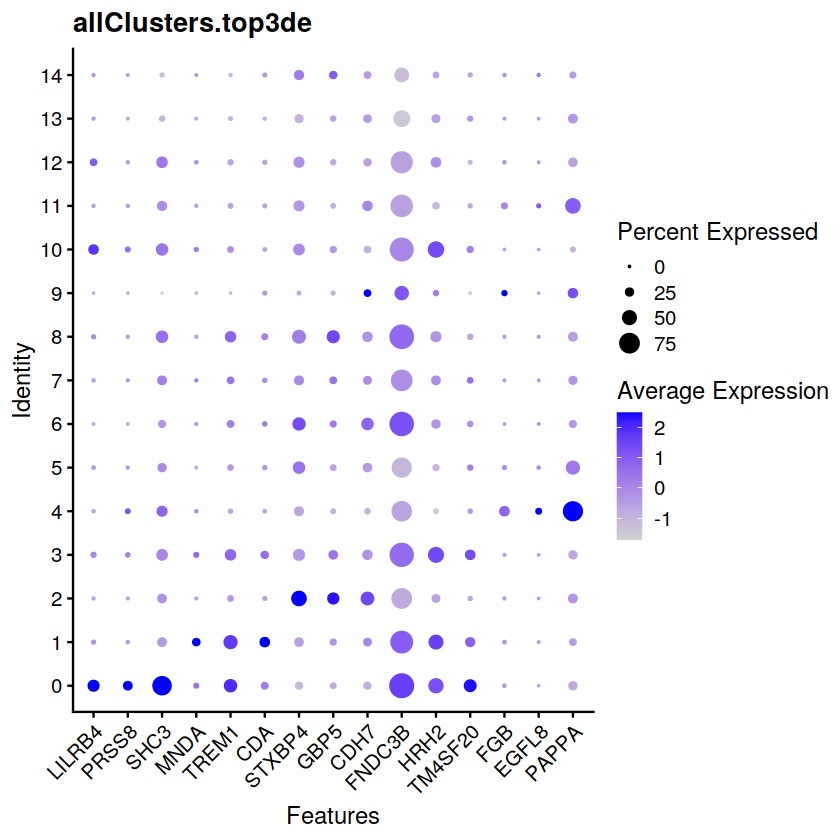

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



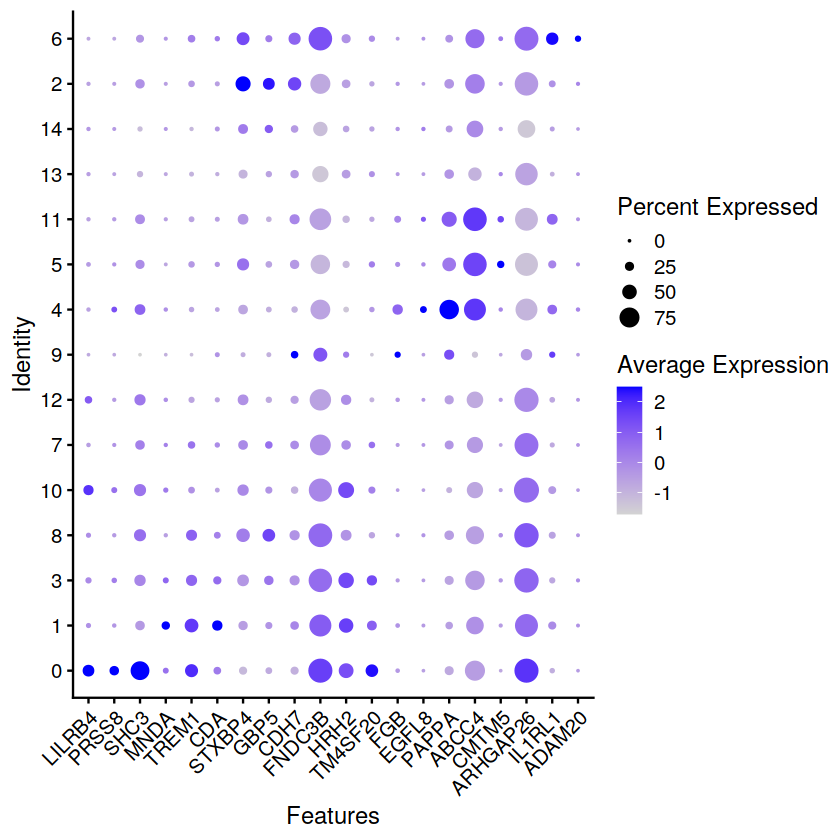

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



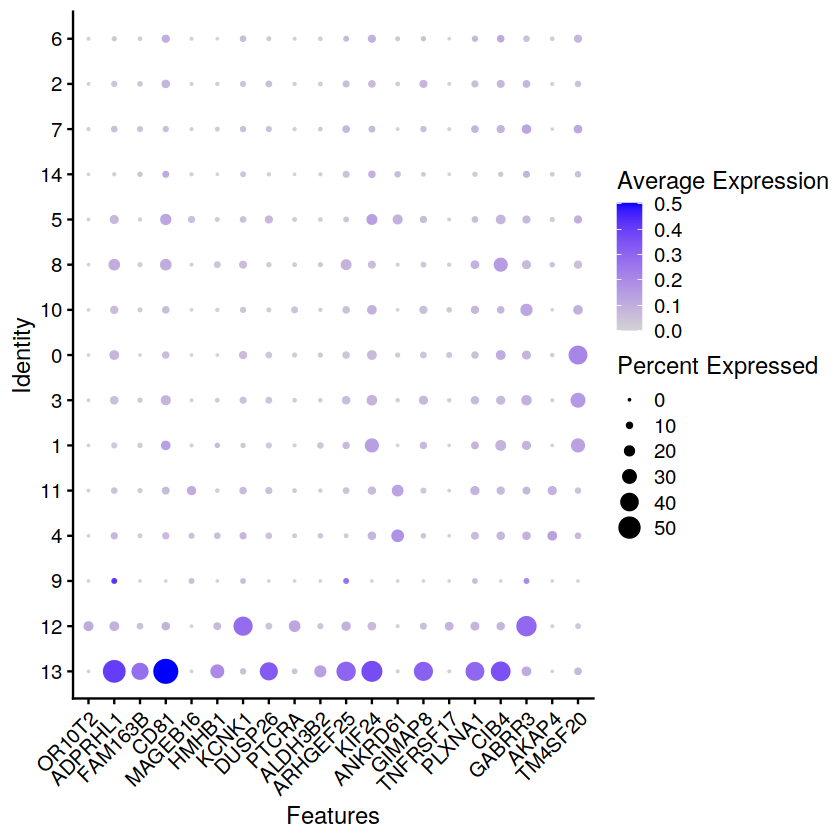

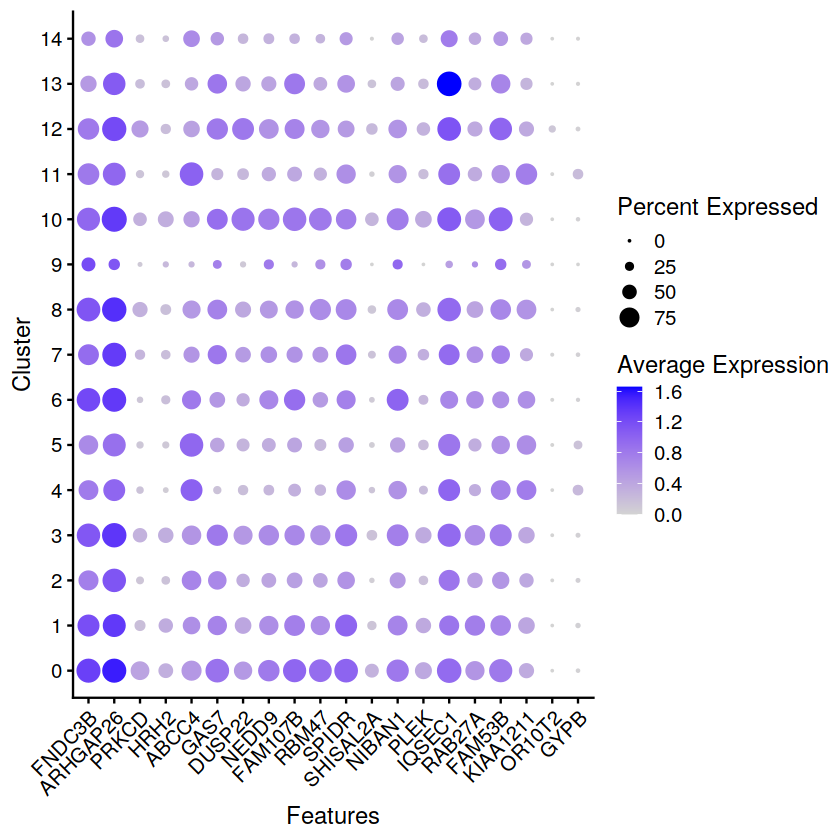

In [10]:
btwnClust.outdir <- file.path(outdir, "btwnClust")
dir.create(btwnClust.outdir)


curr.outdir <- btwnClust.outdir

cluster.ids <- sort(unique(se$seurat_clusters))
Idents(se) <- se$seurat_clusters

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()
for (id1 in cluster.ids){ #or however many clusters you have
try({
    print(paste("cluster", id1))
    response <- FindMarkers(
                  object = se,
                  ident.1 = id1, #"CD4 Naive",
                  min.pct = minPct, logfc.threshold=logfcthresh,
                  test.use = 'wilcox', latent.vars = NULL
                )
    print(head(response))
    #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
    
    
    print(paste('saved cluster', id1))
    response <- response %>% dplyr::arrange(p_val)
    response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
    write.csv(response,
              file=file.path(curr.outdir, paste0("cluster",id1,".DE.csv")), quote=F)
    
    curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
    
    
    names.sig <- rownames(curr.sig)
    se.filt <- subset(se, seurat_clusters == id1)
    
    # Add to all pvals
    all.names.sig <- c(all.names.sig, head(names.sig, top_de))
    all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
    de.plots(se.filt, names.sig, curr.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)
    
})
}


all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, curr.outdir, curr.name="allClusters.top3de", max.size=15)

dot <- DotPlot(se, scale=T,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.top3de.png"))
ggsave(file.path(curr.outdir, "allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.png"))
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.png"))
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.pdf"))
dot

In [11]:
btwn_embeddings <- file.path(btwnClust.outdir, "embeddings")
dir.create(btwn_embeddings)


featplot <- function(name.sig, se, curr.outdir){
    feat <- FeaturePlot(se,  features=name.sig)
    ggsave(plot=feat,
           file=file.path(curr.outdir, paste0(name.sig,".embedFeat.top.png")))
    }

sapply(all.names.sig, FUN=featplot, se=se, curr.outdir=btwn_embeddings)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

LILRB4 
  "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/LILRB4.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                PRSS8 
   "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/PRSS8.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                 SHC3 
    "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/SHC3.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                 MNDA 
    "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/MNDA.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                TREM1 
   "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/TREM1.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                  CDA 
     "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_A2_black/annotation_clones/input_cond/DE_minPct_00_pval0.1/v02/btwnClust/embeddings/CDA.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                               STXBP4 
  "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merg

---

---

---

In [12]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 